# Hub 2.0 Send dog breeds dataset to Hub Storage.ipynb
Author: Margaux Masson-Forsythe

## Imports

In [1]:
!pip3 install hub==2.0.4 
# restart runtime after installing

In [2]:
import numpy as np
import hub
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
from torchsummary import summary
import torchvision.models as models
import glob
from PIL import Image
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
print(hub.__version__)

2.0.4


## Load Data: Dog breeds from https://www.kaggle.com/eward96/dog-breed-images

In [4]:
!export KAGGLE_USERNAME="username" && export KAGGLE_KEY="password" && mkdir -p data && cd data && kaggle datasets download -d eward96/dog-breed-images && unzip -n dog-breed-images.zip && rm dog-breed-images.zip

 90% 83.0M/91.7M [00:00<00:00, 146MB/s]
100% 91.7M/91.7M [00:00<00:00, 170MB/s]
Archive:  dog-breed-images.zip


In [5]:
!ls data

bernese_mountain_dog  chihuahua  dachshund	   jack_russell  pug
border_collie	      corgi	 golden_retriever  labrador	 siberian_husky


In [6]:
data_dir = 'data'

In [7]:
list_imgs = glob.glob(data_dir + "/**/*.jpg")
print(f"There are {len(list_imgs)} images in the dataset {data_dir}")

There are 918 images in the dataset data


Display the first image

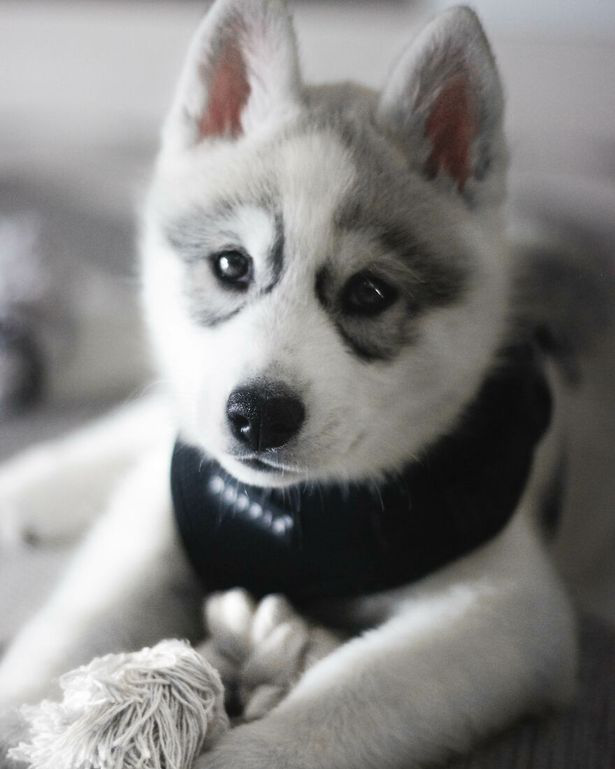

In [8]:
Image.open(list_imgs[0]).show()

## Send to Hub

In [9]:
!activeloop login -u username -p password

Successfully logged in to Activeloop.


In [10]:
hub_dataset_path = 'hub://username/dog_breeds'

In [11]:
# Find the class_names and list of files that need to be uploaded
dataset_folder = './data'

class_names = os.listdir(dataset_folder)

files_list = []
for dirpath, dirnames, filenames in os.walk(dataset_folder):
    for filename in filenames:
        files_list.append(os.path.join(dirpath, filename))
print(class_names)

['siberian_husky', 'jack_russell', 'pug', 'bernese_mountain_dog', 'golden_retriever', 'dachshund', 'border_collie', 'chihuahua', 'labrador', 'corgi']


In [12]:
with hub.empty(hub_dataset_path) as ds:
    # Create the tensors with names of your choice.
    ds.create_tensor('images', htype = 'image', sample_compression = 'jpeg')
    ds.create_tensor('labels', htype = 'class_label', class_names = class_names)

    # Add arbitrary metadata - Optional
    ds.info.update(description = 'Dog breeds dataset')
    ds.images.info.update(camera_type = 'SLR')
    
    # Iterate through the files and append to hub dataset
    for file in tqdm(files_list):
        label_text = os.path.basename(os.path.dirname(file))
        label_num = class_names.index(label_text)
        
        ds.images.append(hub.read(file))  # Append to images tensor using hub.read
        ds.labels.append(np.uint32(label_num)) # Append to labels tensor
                
# Long-term storage is updated at the end of the code block inside 'with'

Your Hub dataset has been successfully created!


100%|██████████| 918/918 [00:16<00:00, 54.15it/s]


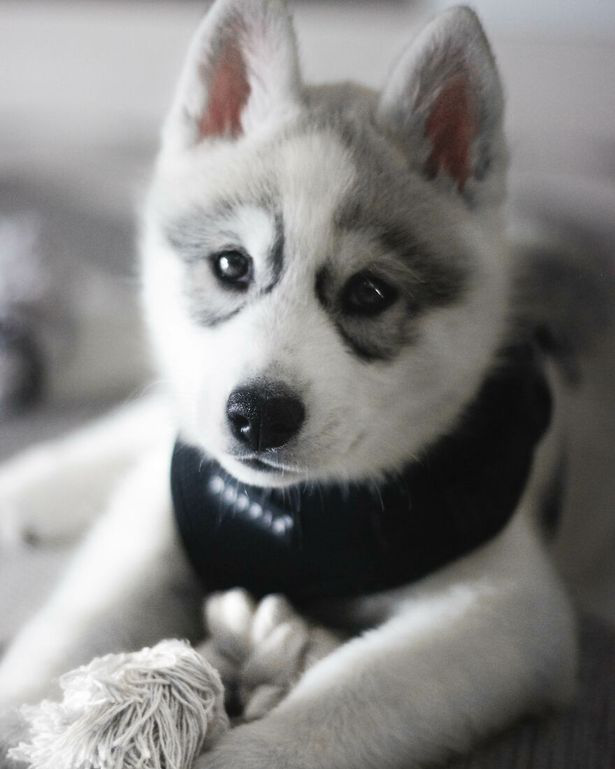

In [13]:
Image.fromarray(ds.images[0].numpy())

## Check the Hub Dataset was correctly uploaded

hub://margauxmforsythe/dog_breeds loaded successfully.


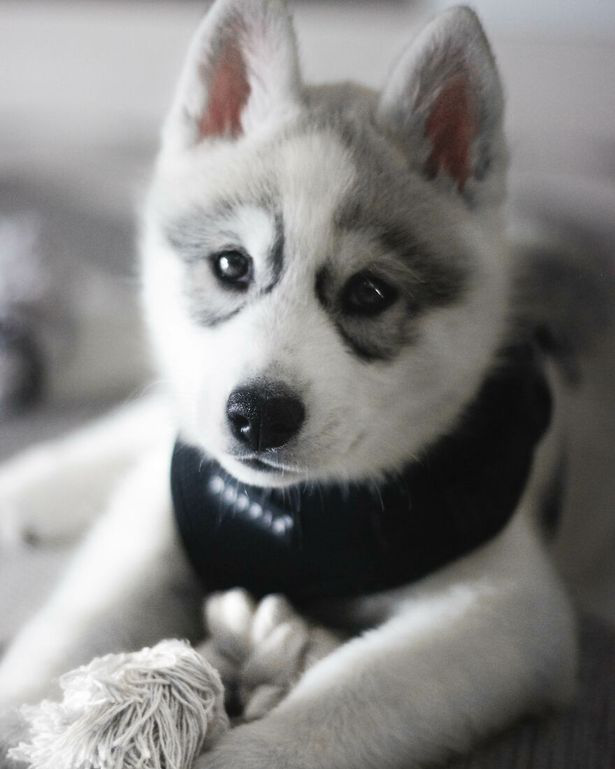

In [14]:
ds_from_hub = hub.dataset(hub_dataset_path)
Image.fromarray(ds_from_hub.images[0].numpy())